In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import rbf_kernel
from and_logic_generator import get_not_y

In [2]:
# we create 40 separable points
random_state = 2**3
x, y = make_blobs(n_samples=40, centers=2, random_state=random_state)

In [3]:
# fit the model, don't regularize for illustration purposes
model = svm.SVC(kernel='rbf', C=100, gamma='scale')
model.fit(x, y)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [4]:
x0_mean = x[:, 0].mean()
x0_min = x[:, 0].min() - x0_mean * 0.5
x0_max = x[:, 0].max() + x0_mean * 0.5
x1_mean = x[:, 1].mean()
x1_min = x[:, 1].min() - x1_mean * 0.5
x1_max = x[:, 1].max() + x1_mean * 0.5

In [5]:
x_test = np.array([[6.0, 1.0], [8.0, 2.0], [10.0, 10.0]], dtype=np.float32)
pred_test = model.predict(x_test)
print(pred_test)

score = model.decision_function(x_test)
print(score)

[1 1 0]
[ 1.20393357  1.07982708 -0.91837726]


In [6]:
y_sign = np.array([[-1 if yy == 0 else 1 for yy in pred_test]], dtype=np.float32).T

In [7]:
sup_x = model.support_vectors_ # 8x2
dual_alpha = model.dual_coef_ # 1x8
beta = model.intercept_
gamma = model._gamma

print('sup_x', sup_x.shape)
print('dual_alpha', dual_alpha.shape)
print('gamma', gamma)

print('x test', x_test.shape)

sup_x (8, 2)
dual_alpha (1, 8)
gamma 0.04089030167538266
x test (3, 2)


In [9]:
def get_gradient_rbf(support_x, dual_alpha, x, gamma, rbf):
    grad_df = None
    for ww, xx in zip((2.0 * gamma * dual_alpha.T * rbf).T, x):
        grad_temp = ww @ (support_x-xx)
        if grad_df is None:
            grad_df = grad_temp
        else:
            grad_df = np.vstack((grad_df, grad_temp))
    return grad_df


In [10]:
learning_rate = 1.2
x_star = np.array(x_test)
not_y = get_not_y(pred_test)
pred_x_star = model.predict(x_star)
update_inds = np.where(pred_x_star != not_y)[0]

epoch = 0
max_epochs = 20
while len(update_inds) > 0 and epoch < max_epochs:
    rbf = rbf_kernel(sup_x, x_star[update_inds], gamma=gamma)
    update_x = x_star[update_inds] - y_sign[update_inds] * learning_rate * get_gradient_rbf(sup_x, dual_alpha, x, gamma, rbf)
    x_star[update_inds] = update_x

    pred_x_star = model.predict(x_star)
    update_inds = np.where(pred_x_star != not_y)[0]
    epoch = epoch + 1
    
print('before df = ', model.decision_function(x_test))
print(f'after {epoch} epochs df = ', model.decision_function(x_star))

before df =  [ 1.20393357  1.07982708 -0.91837726]
after 9 epochs df =  [-0.10398486 -0.05508717  0.09876074]


In [11]:
print('x_test\n', x_test)
pred_test = model.predict(x_test)
print('pred_test\n', pred_test)

adversarial = np.array(x_star)

print('adversarial\n', adversarial)

ad_pred = model.predict(adversarial)
print('ad_pred\n', ad_pred)

x_test
 [[ 6.  1.]
 [ 8.  2.]
 [10. 10.]]
pred_test
 [1 1 0]
adversarial
 [[ 5.634501   5.4146533]
 [ 6.210853   5.309034 ]
 [10.225094   5.1962504]]
ad_pred
 [0 0 1]


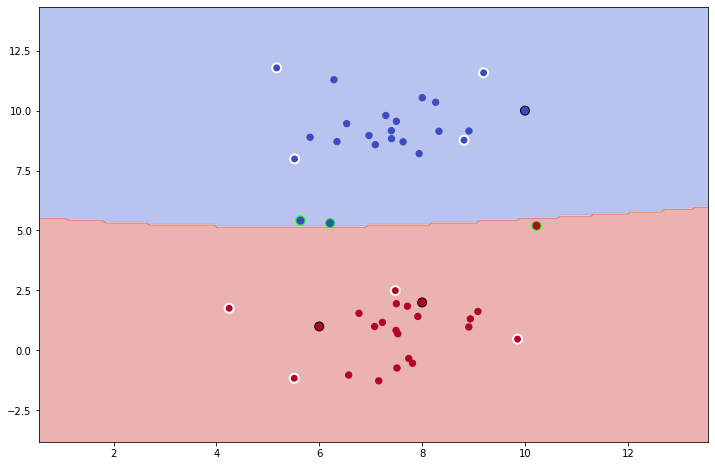

In [12]:
XX, YY = np.mgrid[x0_min:x0_max:200j, x1_min:x1_max:200j]
Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

figsize = np.array(plt.rcParams["figure.figsize"]) * 2
plt.figure(figsize=figsize.tolist())

plt.contourf(XX, YY, Z, cmap='coolwarm', alpha=0.4, zorder=1)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', edgecolor='face', s=40, zorder=2)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], c=y[model.support_], cmap='coolwarm', edgecolors='white', linewidths=2, s=80, zorder=10)

pred_test = model.predict(x_test)
plt.scatter(x_test[:, 0], x_test[:, 1], c=pred_test, cmap='coolwarm', edgecolor='k', s=80, zorder=20)
plt.scatter(adversarial[:, 0], adversarial[:, 1], c=ad_pred, cmap='coolwarm', edgecolor='lime', s=80, zorder=20)

plt.xlim(x0_min, x0_max)
plt.ylim(x1_min, x1_max)
plt.show()